## Máster en Data Science

### Machine Learning

Contacto: angel.blanco@cunef.edu

# **Modelaje inicial**

En este notebook se realiza el proceso de modelaje inicial con diferentes tipos de modelos para, en posteriores notebooks, evaluarlos, seleccionar el mejor y refinar sus hiperparámetros.

### Librerías

In [52]:
import os
from pathlib import Path

# Cambio del directory al root del proyecto
current_dir = Path.cwd()

if current_dir.name == "notebooks":
    os.chdir(current_dir.parent)

# Procesamiento
import pandas as pd
from sklearn.model_selection import train_test_split

# Modelo base
from sklearn.dummy import DummyClassifier

# Funciones
from src.metrics import get_metrics
from src.data import read_train, read_test, write_csv
from src.models import write_model

# Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from lightgbm import LGBMClassifier

# Tiempo de ejecución
import time

# Diseño
from pathlib import Path

# Omitir warnings
import warnings
warnings.filterwarnings('ignore')

# Undersampling
from imblearn.over_sampling import SMOTE

# Gráficos
import plotnine as pn
from plotnine import aes

### Lectura de datos

In [2]:
x_train, y_train = read_train()
x_test, y_test = read_test()

### Split de validación

In [3]:
# Divido los datos de entrenamiento en un conjunto de entrenamiento y un conjunto de validación
x_train, x_val, y_train, y_val = train_test_split(
    x_train,
    y_train,
    test_size=0.2,
    random_state=42,
    stratify=y_train['fraud_bool']
)

In [4]:
write_csv(x_train, 'data/processed/x_train_selected.csv')
write_csv(y_train, 'data/processed/y_train.csv')
write_csv(x_val, 'data/processed/x_val.csv')
write_csv(y_val, 'data/processed/y_val.csv')


### **Modelo base**

El modelo base o modelo es aquel que asigna la media u otro valor simple como prediccion del suceso. En este caso, el modelo base imputará el valor más frecuente

In [5]:
# Construcción
modelo_base = DummyClassifier(
    strategy='most_frequent', # predice el valor más frecuente en el dataset 
    random_state=1234
)

In [6]:
# Entrenamiento 
modelo_base.fit(x_train, y_train)

DummyClassifier(random_state=1234, strategy='most_frequent')

In [7]:
# Accuracy del modelo 
modelo_base.score(x_val, y_val) # un 98.891%. Es coherente, es la proporción real 

0.9889678955078125

In [8]:
y_pred = modelo_base.predict(x_val)
y_prob = modelo_base.predict_proba(x_val)

get_metrics(y_true=y_val, y_pred=y_pred, y_prob=y_prob)

{'accuracy': 0.9889678955078125,
 'precission': 0.0,
 'recall': 0.0,
 'f1_score': 0.0,
 'f2_score': 0.0,
 'ROC_0': 0.5,
 'ROC_1': 0.5}

Guardo el modelo base para comparar con el resto después.

In [9]:
# Guardo en pickle
write_model(model=modelo_base, name="modelo_base")

### **Modelos**

In [10]:
# Oversampling
smote = SMOTE(random_state=42, sampling_strategy=0.25)

x_resampled, y_resampled = smote.fit_resample(x_train, y_train)

In [11]:
write_csv(x_resampled, 'data/processed/x_resampled.csv')
write_csv(y_resampled, 'data/processed/y_resampled.csv')

In [12]:
x_train = x_resampled
y_train = y_resampled

In [13]:
n_jobs = 4

models = [
    LogisticRegression(n_jobs=n_jobs, max_iter=5000),
    RandomForestClassifier(n_estimators=500),
    DecisionTreeClassifier(),
    GradientBoostingClassifier(),
    LGBMClassifier(verbose=-1)
]

In [14]:
# Computamos las métricas para ambos sets para ver si hay overfitting
sets = {
    "train": {"x": x_train, "y": y_train},
    "validation": {"x": x_val, "y": y_val}
}

rows = []

for model in models:

    # Entrenamiento
    name = model.__class__.__name__
    start_train = time.perf_counter()
    model.fit(x_train, y_train)
    end_train = time.perf_counter()
    
    eta_train = end_train - start_train
    
    write_model(model=model, name=name)
    
    print(f'Saved model "{name}"')
    
    # Cálculo de métricas contra ambos sets
    for set_name, set_data in sets.items():
        
        start_predict = time.perf_counter()
        y_pred = model.predict(set_data["x"])
        end_predict = time.perf_counter()

        eta_predict = end_predict - start_predict

        y_prob = model.predict_proba(set_data["x"])
        
        # Ccombinación de diccionarios
        metrics = {
            "model": name,
            "set": set_name,
            "training_time (min)": eta_train/60,
            "predict_time (sec)": eta_predict} | get_metrics(y_true=set_data["y"], y_pred=y_pred, y_prob=y_prob)  # esto devuelve un diccionario

        # Pandas requiere una lista
        metrics =  {key: [value] for key, value  in metrics.items()}
        
        rows.append( pd.DataFrame(metrics) )

all_metrics = pd.concat(rows).round(4)

Saved model "LogisticRegression"
Saved model "RandomForestClassifier"
Saved model "DecisionTreeClassifier"
Saved model "GradientBoostingClassifier"
Saved model "LGBMClassifier"


En problemas de clasificación con conjuntos de datos desbalanceados, las métricas de precisión y accuracy pueden ser engañosas porque pueden dar una imagen demasiado optimista del rendimiento del modelo. A mayores de estas, he considerado estas otras métricas que aparecen el la tabla:

- Time: el tiempo que tarda el modelo en conseguir objetivos es importante a la hora de contrastar si compensa su resultado o no. Puedo tener un modelo que haga predicciones genial pero que tarde demasiado tiempo en ejecutarse comparado con otro de resultados algo menores, lo que se traduce en más costes para la organización.

- Accuracy (Exactitud): calcula la fracción de predicciones que un modelo realizó correctamente. Es una buena métrica cuando tenemos un conjunto de datos balanceado, es decir, cuando el número de etiquetas de cada clase es similar (lo cual no es nuestro caso). Representa el porcentaje total de valores correctamente clasificados, tanto positivos como negativos.

- Precission (Precisión): mide la proporción de identificaciones positivas que fueron realmente correctas.

- Recall (Sensibilidad): es bastante útil cuando la clase de interés es la minoritaria. Mide la proporción de positivos reales que se identifican correctamente.

- F1 Score: media armónica de la precisión y la sensibilidad. Combina ambas métricas en una sola cifra y es útil cuando quieres buscar un equilibrio entre precisión y        
sensibilidad.

- F2 Score:  es una variante de la medida F que da más peso a la sensibilidad que a la precisión.

- ROC: la curva ROC es una representación gráfica que muestra el rendimiento de un modelo de clasificación en todos los umbrales de clasificación. Un AUC de 1 indica que el modelo tiene una capacidad perfecta para distinguir entre las clases. Un AUC de 0.5 indica que el modelo no tiene capacidad para distinguir entre las clases.

La elección de la métrica depende del problema específico que estemos tratando de resolver y de si consideramos más importante en ese caso minimizar los falsos positivos o maximizar los verdaderos positivos. Veamos primero resultados y luego tratamos lo que he elegido hacer.

In [15]:
all_metrics

,model,set,training_time (min),predict_time (sec),accuracy,precission,recall,f1_score,f2_score,ROC_0,ROC_1
0,LogisticRegression,train,0.0983,0.0356,0.9217,0.8265,0.7699,0.7972,0.7806,0.0391,0.9609
0,LogisticRegression,validation,0.0983,0.0045,0.9533,0.0903,0.3568,0.1442,0.2244,0.1610,0.8390
0,RandomForestClassifier,train,2.8581,23.2595,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000
0,RandomForestClassifier,validation,2.8581,6.0899,0.9869,0.1881,0.0567,0.0871,0.0659,0.1493,0.8507
0,DecisionTreeClassifier,train,0.0588,0.0878,1.0000,1.0000,1.0000,1.0000,1.0000,0.0000,1.0000
0,DecisionTreeClassifier,validation,0.0588,0.0144,0.9695,0.0672,0.1369,0.0902,0.1134,0.4421,0.5579
0,GradientBoostingClassifier,train,1.1667,0.8162,0.9540,0.9326,0.8300,0.8783,0.8487,0.0148,0.9852
0,GradientBoostingClassifier,validation,1.1667,0.1382,0.9773,0.1555,0.2379,0.1881,0.2151,0.1426,0.8574
0,LGBMClassifier,train,0.0858,1.4783,0.9883,0.9944,0.9469,0.9701,0.9560,0.0047,0.9953
0,LGBMClassifier,validation,0.0858,0.2017,0.9881,0.3028,0.0595,0.0994,0.0709,0.1283,0.8717


### Gráficos

In [16]:
# Cambio a formato largo de los datos para graficar
exclude = ['model', 'set']
id_vars = ['model']
value_vars = [i for i in metrics.columns if not i in exclude]
var_name = 'metric'
value_name = 'value'

train_melted = (
    metrics
        .query("set == 'train'")
        .melt(
            id_vars=id_vars,
            value_vars=value_vars,
            var_name=var_name,
            value_name=value_name
        )
)


val_melted = (
    metrics
        .query("set == 'validation'")
        .melt(
             id_vars=id_vars,
             value_vars=value_vars,
             var_name=var_name,
             value_name=value_name
        )
)

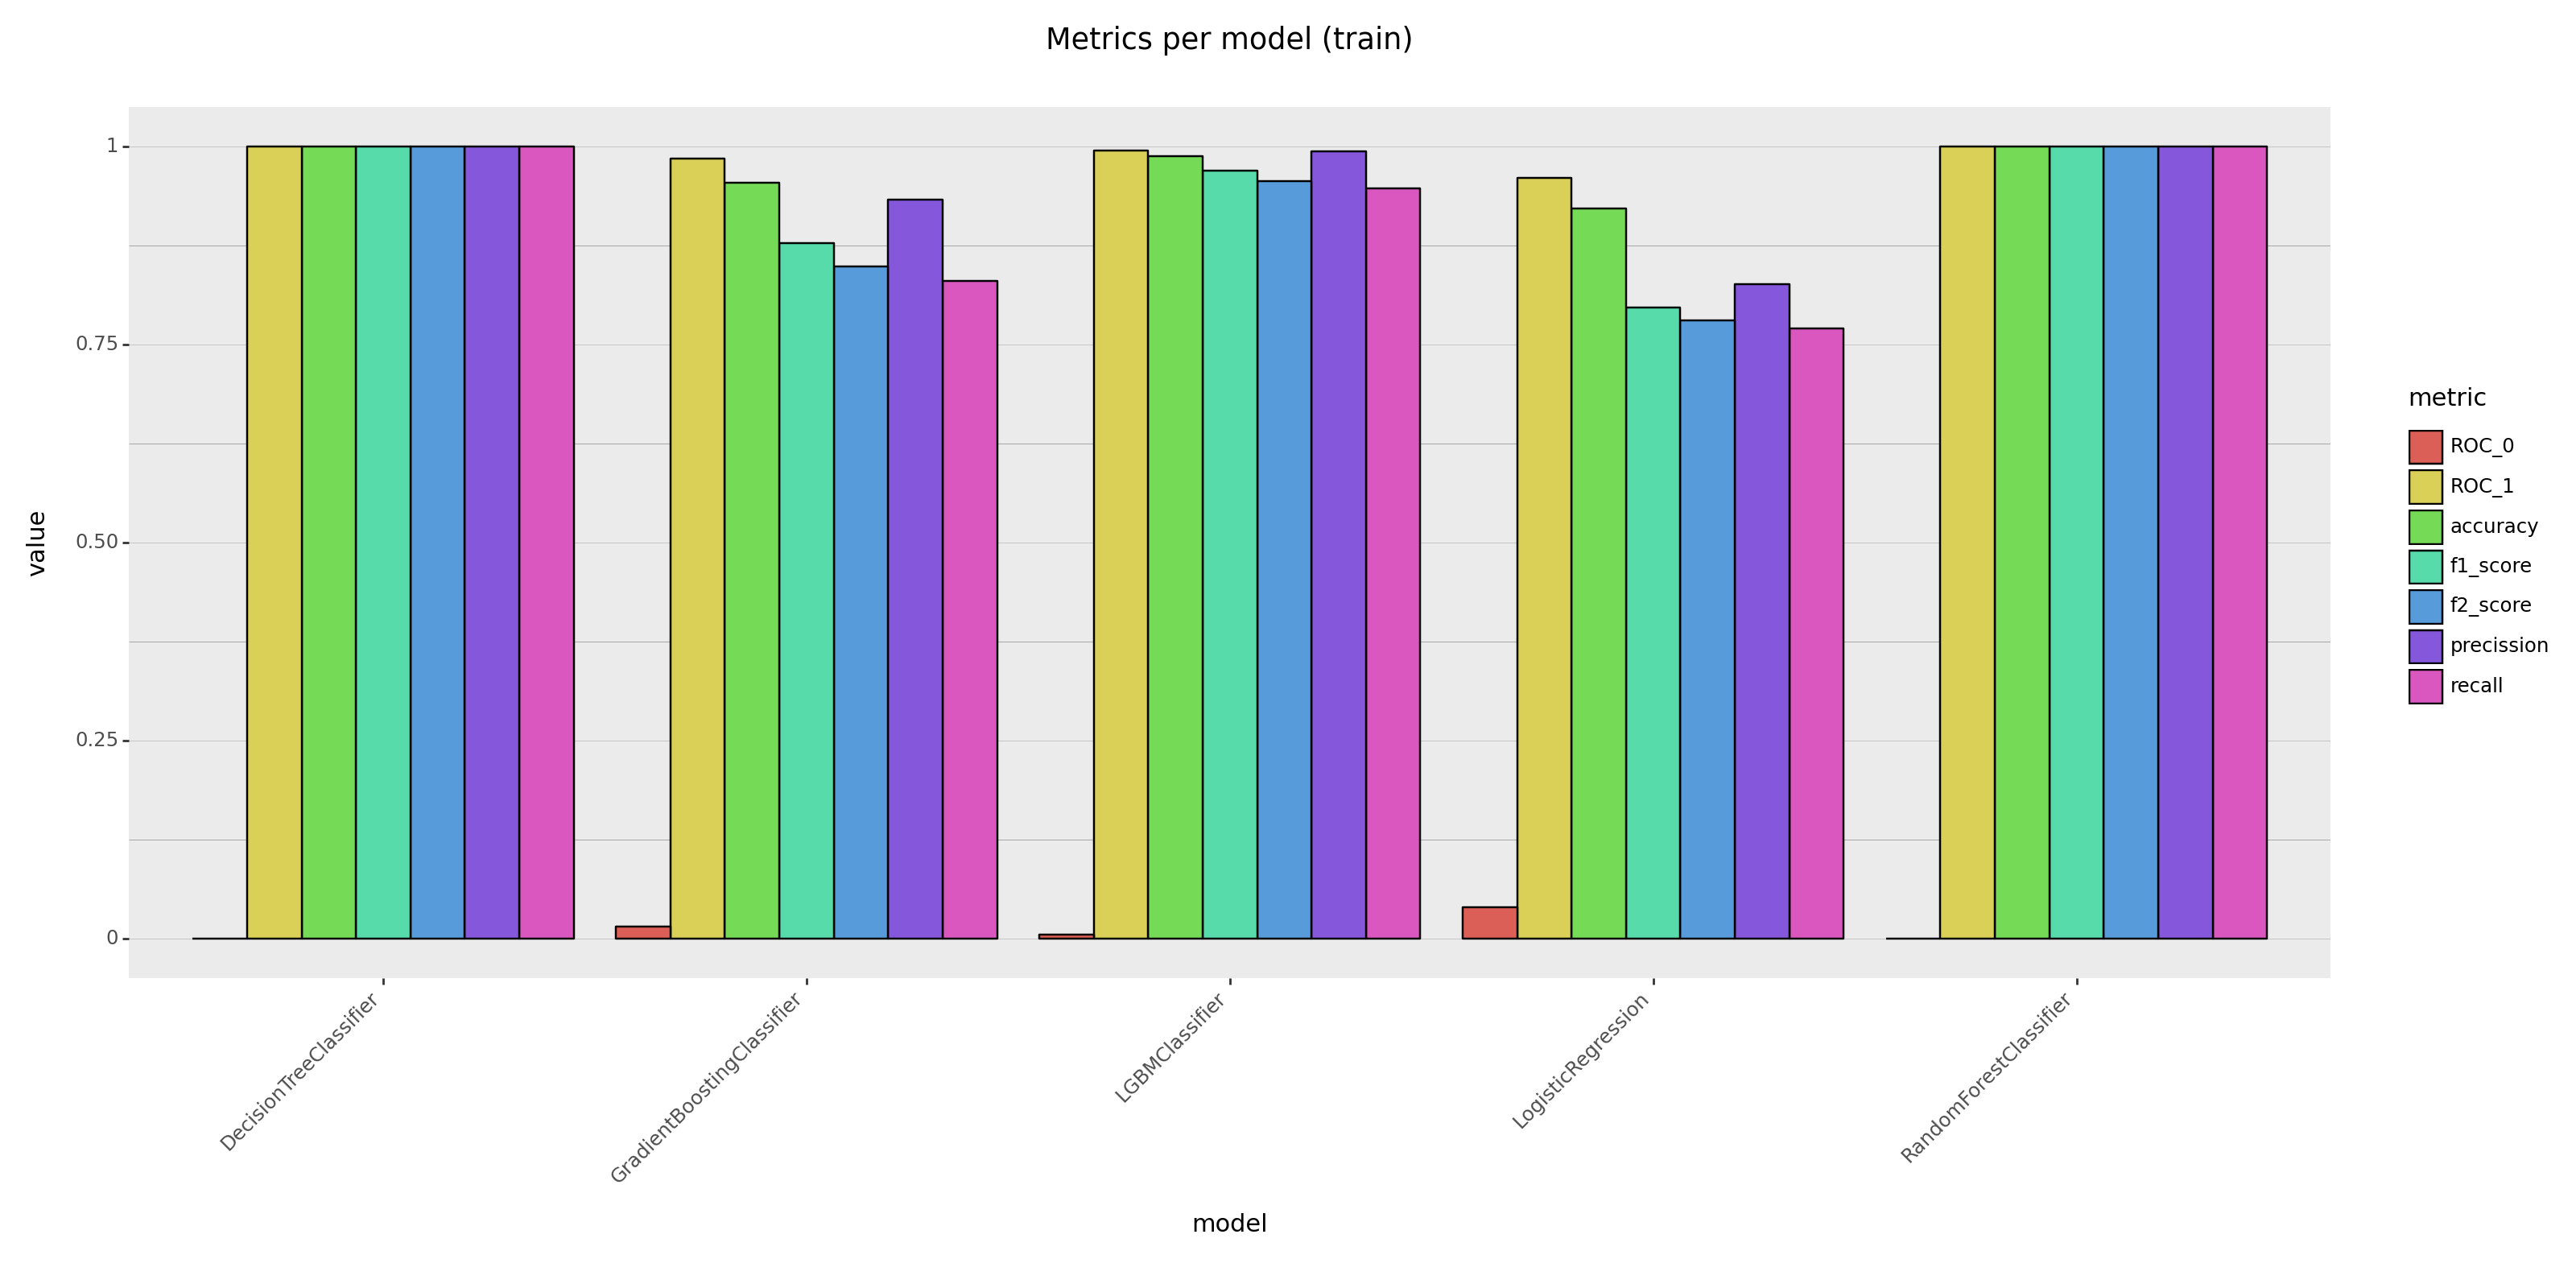

<Figure Size: (1600 x 800)>

In [97]:
(
    pn.ggplot(data=train_melted.query("~metric.str.contains('_time')")) +
      pn.geom_col(
          pn.aes(x='model', y='value', fill='metric'),
          color='black',
          position='dodge'
    ) +
    pn.labs(title='Metrics per model (train)') +
    pn.theme(
        # Rotación del eje X
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        figure_size=(16, 8),

        # Cuadrícula en el eje Y
        panel_grid_major_y=pn.element_line(color="grey", size=0.25, alpha=0.5),
        panel_grid_minor_y=pn.element_line(color="grey", size=0.25, alpha=0.9),
        panel_grid_major_x=pn.element_blank(),
        panel_grid_minor_x=pn.element_blank(),
        
        # Título centrado
        plot_title=pn.element_text(hjust=0.5)
    )
    
)

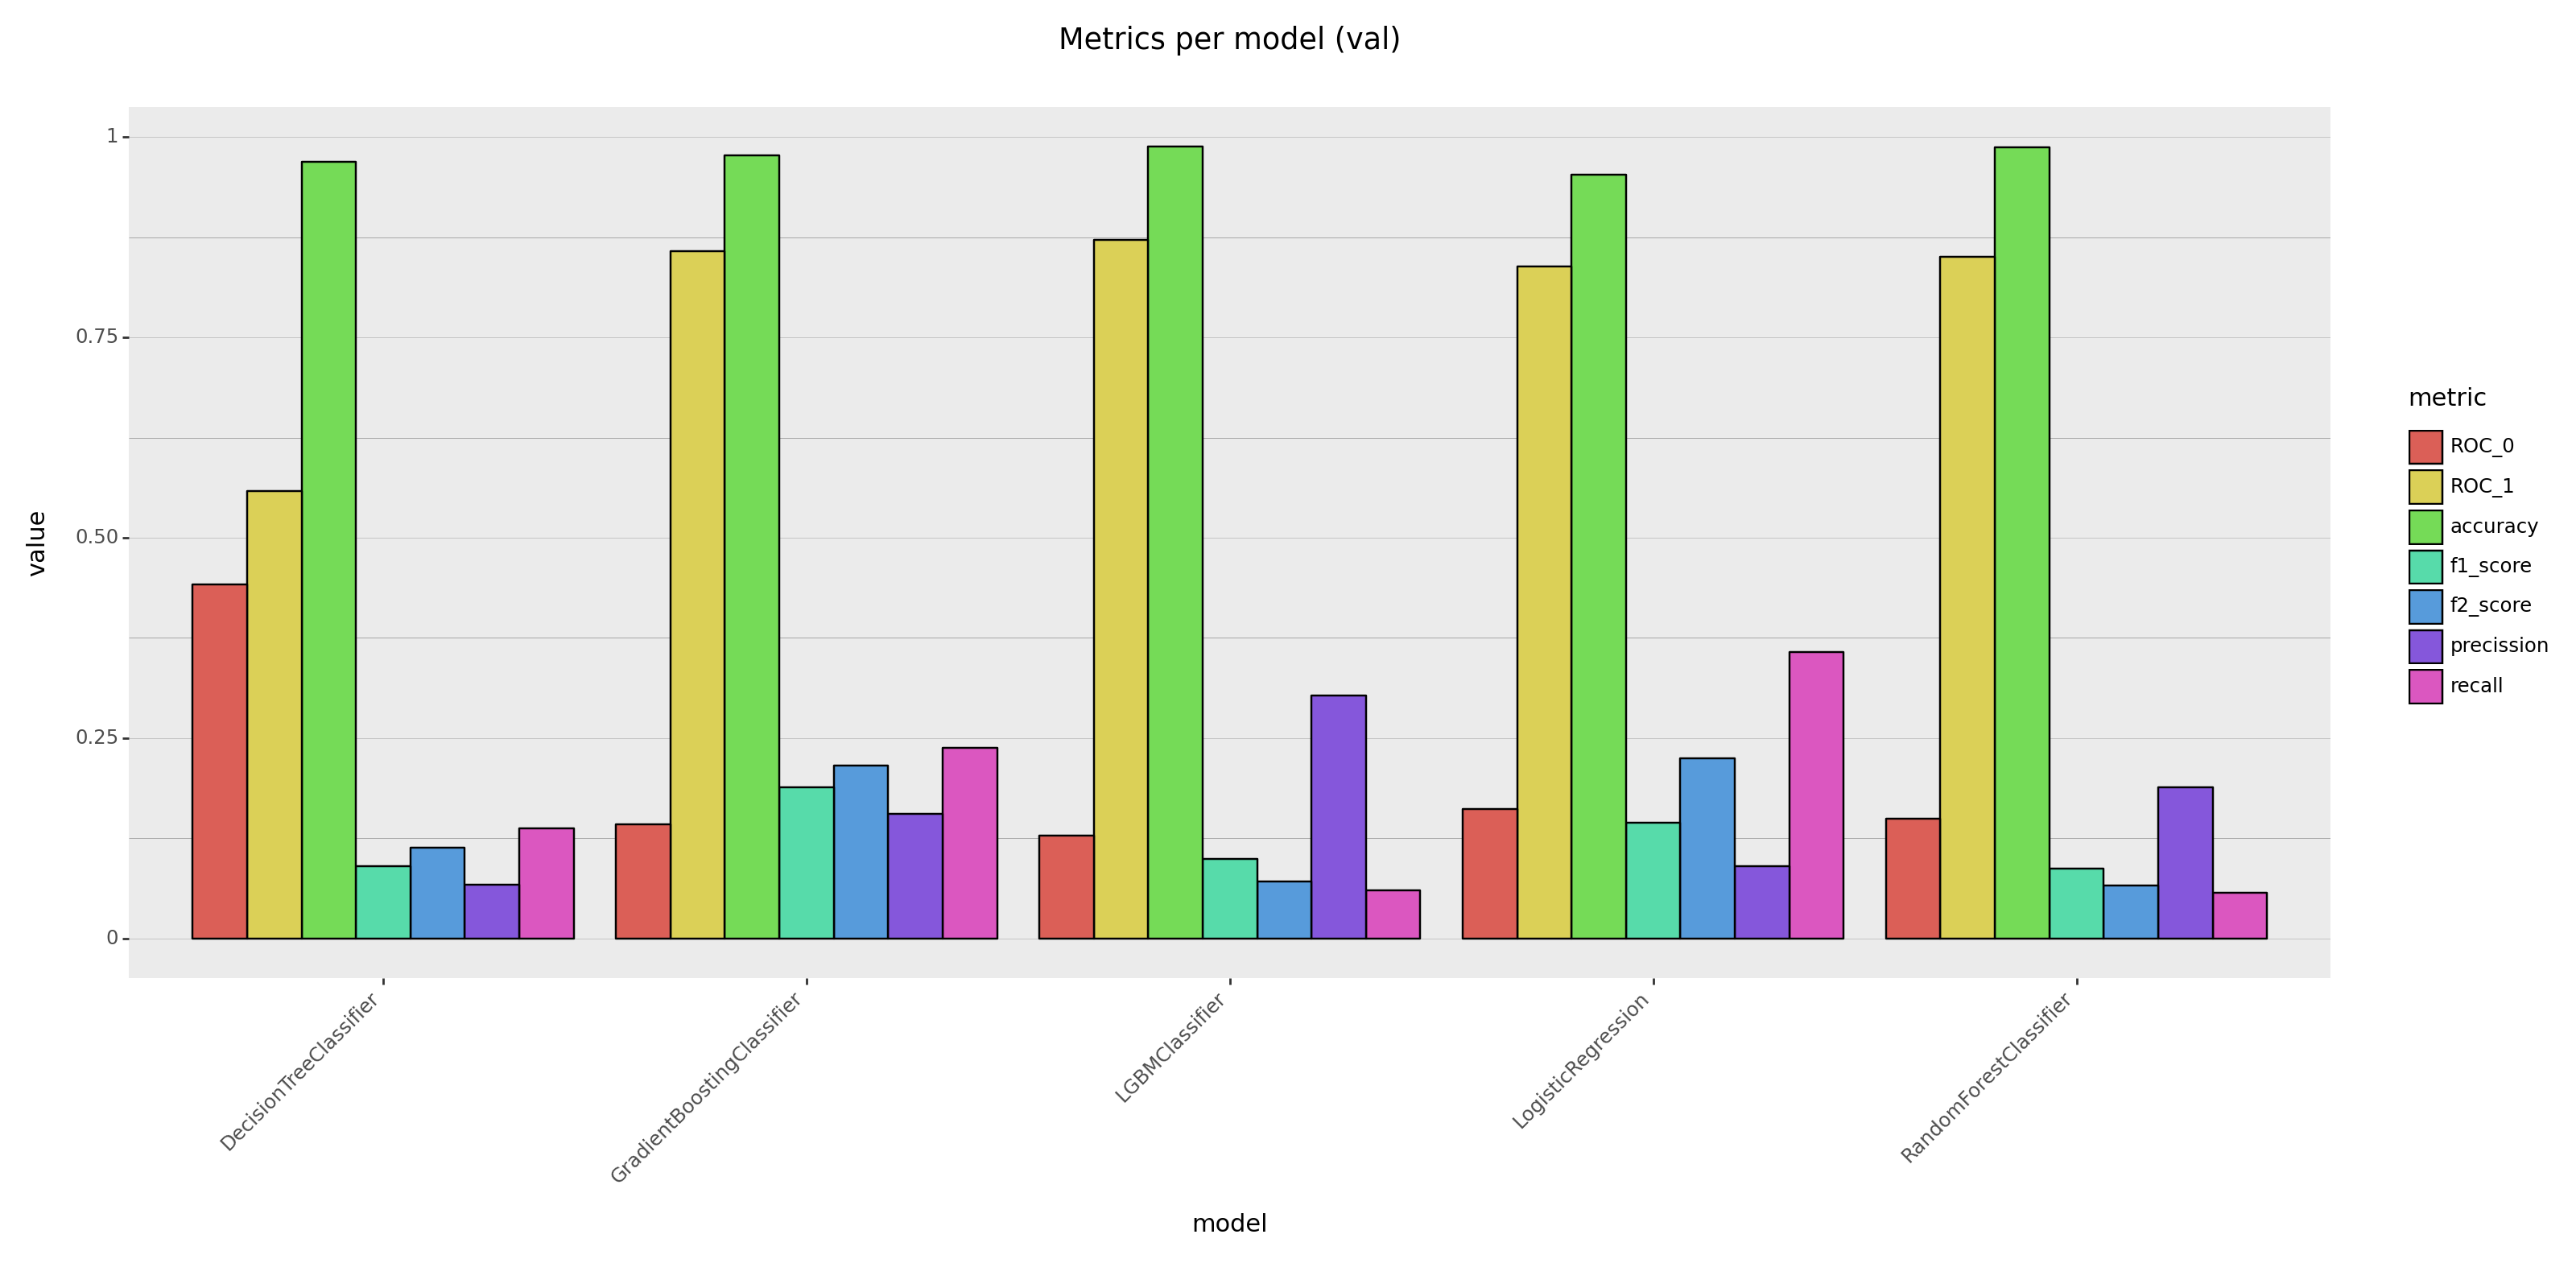

<Figure Size: (1600 x 800)>

In [95]:
(
    pn.ggplot(data=val_melted.query("~metric.str.contains('_time')")) +
    pn.geom_col(
        pn.aes(x='model', y='value', fill='metric'),
        color='black',
        position='dodge'
    ) +
    pn.labs(title='Metrics per model (val)') +
    pn.theme(
        # Rotación del eje X
        axis_text_x=pn.element_text(rotation=45, hjust=1),
        figure_size=(16, 8),
        
        # Cuadrícula en el eje Y
        panel_grid_major_y=pn.element_line(color="grey", size=0.25, alpha=0.5),
        panel_grid_minor_y=pn.element_line(color="grey", size=0.25, alpha=0.9),
        panel_grid_major_x=pn.element_blank(),
        panel_grid_minor_x=pn.element_blank(),
        
        # Título centrado
        plot_title=pn.element_text(hjust=0.5)
    )
)

Se ha usado un Oversampling con SMOTE al 25% (por defecto viene al 50%).  

En cuanto a las métricas, en este caso se ha dado **prioridad a minimizar los falsos negativos**, puesto que le costarían mucho más dinero a la organización y podrían meterla en problemas de solvencia. Teniendo esto en cuenta, la métrica que se ha priorizado es la f2_score, por ser la más adecuada para esta premisa.  

Comparando los gráficos, se observa que los modelos tienen overfitting (se comportan muy bien en el train, pero en validación su rendimiento es mucho menor). Esto ocurre de manera más pronunciada en los modelos más complejos porque, al entrenar, se sobreajustan al dataset de train, no pudiendo generalizar bien a nuevos datos. También es posible que se de por falta de entrenamiento o un entrenamiento anómalo, por exceso de ruido en los datos de muestra, o porque hayan entrenado con muchos datos.

Para evitar el overfitting, suelen utilizarse técnicas como la Data Augmentation o la validación cruzada.

El modelo que mejor se comporta teniendo en cuenta también el tiempo es la **LogisticRegression** (el GradientBoostingClassifier tarda significativamente más pese a obtener resultados similares).

In [16]:
# Guardado de resultados
write_csv(all_metrics,  'tables/metrics.csv')